In [ ]:
!pip install --upgrade --user ortools

In [2]:
import json
import pandas as pd
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt
with open('hard_input.json', mode='r') as f:
    dat = json.load(f)

In [3]:
couriers = pd.DataFrame(data = dat['couriers'])
depots = pd.DataFrame(data = dat['depots'])
orders = pd.DataFrame(data = dat['orders'])

In [4]:
orders.iloc[0]['payment'] =400
orders.iloc[3]['payment'] = 1500
orders.iloc[4]['payment'] = 200000

In [5]:
def pay(x0,x1,y0,y1,data1):
    if (len(data1[(data1['pickup_location_x'] == x0) & 
                  (data1['pickup_location_y'] == y0) &
                  (data1['dropoff_location_x'] == x1) &
                  (data1['dropoff_location_y'] == y1)]) != 0):
        index = data1[(data1['pickup_location_x'] == x0) & 
                  (data1['pickup_location_y'] == y0) &
                  (data1['dropoff_location_x'] == x1) &
                  (data1['dropoff_location_y'] == y1)].index.values.astype(int)
        payment = data1.iloc[index]['payment']
        print(payment)
    else:
        payment=0
    return(payment)

In [6]:
def TtoSend(x0,x1,y0,y1,data1):
    travel_minutes = 10 + (abs(x0 - x1) + abs(y0 - y1))
    WELLNES = -pay(x0,x1,y0,y1,data1) + travel_minutes*2
    ##########Если че надо добавить условия, чтобы пропускать WELLNES >0
    return(WELLNES)

def compute_time_matrix(locations,data1):
    timesM = {}
    for from_counter, from_node in enumerate(locations):
        timesM[from_counter] = {}
        for to_counter, to_node in enumerate(locations):
            if from_counter == to_counter:
                timesM[from_counter][to_counter] = 0
            else:
                # Time~Distance
                timesM[from_counter][to_counter] =TtoSend(from_node[0],to_node[0],from_node[1],to_node[1],data1)
    
    return(timesM)

In [7]:
couriers

,courier_id,location_x,location_y
0,1,20,20
1,2,50,50
2,3,150,20
3,4,25,150
4,5,100,300


In [8]:
orders

,dropoff_from,dropoff_location_x,dropoff_location_y,dropoff_point_id,dropoff_to,order_id,payment,pickup_from,pickup_location_x,pickup_location_y,pickup_point_id,pickup_to
0,360,60,110,60001,1180,10001,400,360,20,100,40001,1380
1,560,63,130,60002,1380,10002,900,360,55,100,40002,1380
2,360,67,150,60003,720,10003,900,420,16,104,40003,720
3,800,147,84,60004,1400,10004,1500,600,66,92,40004,1200
4,960,164,91,60005,1380,10005,200000,480,156,30,40005,1380


In [9]:
start_cords=[]
end_cords=[]
for i in range(len(orders)):
    start_cords.append([orders['pickup_location_x'][i],orders['pickup_location_y'][i]])
    end_cords.append([orders['dropoff_location_x'][i],orders['dropoff_location_y'][i]])

In [10]:
start_cords

[[20, 100], [55, 100], [16, 104], [66, 92], [156, 30]]

In [11]:
cors = list(zip(couriers.location_x, couriers.location_y))
startCORS = [list(a) for a in cors]

In [12]:
ALL = startCORS + start_cords
ALL
start_cords = ALL + end_cords
###HAS TO BE CHANGED

In [13]:
print(end_cords)
print(start_cords)
start_cords

[[60, 110], [63, 130], [67, 150], [147, 84], [164, 91]]
[[20, 20], [50, 50], [150, 20], [25, 150], [100, 300], [20, 100], [55, 100], [16, 104], [66, 92], [156, 30], [60, 110], [63, 130], [67, 150], [147, 84], [164, 91]]


In [33]:
######Block to work properly#########
'''IMPORTANT STAFF TO CHANGE!!!!!!'''
#manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])
manager = pywrapcp.RoutingIndexManager(len(orders), len(couriers), 0)
routing = pywrapcp.RoutingModel(manager)

time_matrix = compute_time_matrix(ALL,orders)

def time_callback(from_index, to_index):
    """Returns the time between the two nodes."""
    # Convert from routing variable Index to TIMES matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return time_matrix[from_node][to_node]
#Code below could or have to be changed
transit_callback_index = routing.RegisterTransitCallback(time_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

#################################################
dimension_name = 'Distance'
routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        300,  # HAS BEEN CHANGED
        True,  # start cumul to zero
        dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(500)#HAS TO BE CHANGED!!!!

##################################################

search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
#search_parameters.time_limit.seconds = 30
assignment = routing.SolveWithParameters(search_parameters)

#################################################
solution = routing.SolveWithParameters(search_parameters)
#################################################
print(solution)

None


In [15]:
compute_time_matrix(start_cords,orders)[3]

0    400
Name: payment, dtype: int64
1    900
Name: payment, dtype: int64
2    900
Name: payment, dtype: int64
3    1500
Name: payment, dtype: int64
4    200000
Name: payment, dtype: int64


{0: 290,
 1: 270,
 2: 530,
 3: 0,
 4: 470,
 5: 130,
 6: 180,
 7: 130,
 8: 218,
 9: 522,
 10: 170,
 11: 136,
 12: 104,
 13: 396,
 14: 416}

In [20]:
solution

In [18]:
def print_solution(manager, routing, assignment,solution):
    """Prints assignment on console."""
    max_route_distance = 0
    for vehicle_id in range(len(couriers)):
        index = routing.Start(0)
        plan_output = 'Route for vehicle 0:\n'
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} ->'.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index,vehicle_id)
        plan_output += ' {}\n'.format(manager.IndexToNode(index))
        print(plan_output)
        plan_output += 'Route distance: {}miles\n'.format(route_distance)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}m'.format(max_route_distance))
    return(manager, routing, assignment,solution)


In [19]:
manager1, routing1, assignment1=print_solution(manager, routing, assignment,solution)

AttributeError: 'NoneType' object has no attribute 'Value'

In [ ]:
print(assignment1.ObjectiveValue())# All time for one vehicle
print(assignment1.Value(routing.NextVar(0)))# указывает куда надо идти из точки 0.
print(assignment1.Value(routing.NextVar(2)))# the same
print("Time elapsed between 2 and 1 points for 0 vehicle: ",routing.GetArcCostForVehicle(2,1,0))
print("CHECKING")
print(start_cords)
print('Chech with elapsed time',TtoSend(16,55,104,100,orders))
#IT WORKS!!!!
sorted_path =[]
index_to_start = 0
index = routing1.Start(index_to_start)
while not routing1.IsEnd(index):
        sorted_path.append(start_cords[index])
        previous_index = index
        index = assignment.Value(routing.NextVar(index))
print(sorted_path)

In [31]:
def packaged_function(data):
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data['distance_matrix']), data['num_vehicles'], data['depot']
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()

    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    search_parameters.time_limit.seconds = 30

    # Solve the problem.
    assignment = routing.SolveWithParameters(search_parameters)

    return (manager, routing, assignment)

In [32]:
[x,y for a in sorted_path[a]]

SyntaxError: invalid syntax (<ipython-input-32-abae83882c06>, line 1)

In [33]:
x = []
y = []
for a in range(len(sorted_path)):
    x.append(sorted_path[a][0])
    y.append(sorted_path[a][1])

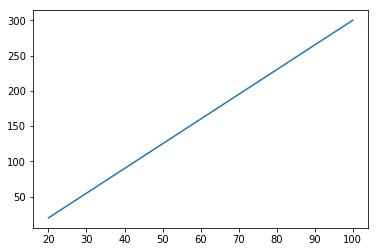

In [34]:
import matplotlib.pyplot as plt
plt.plot(x,y)

In [35]:
"""Prints solution on console."""
max_route_distance = 0
for vehicle_id in range(data['num_vehicles']):
    index = routing.Start(vehicle_id)
    plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
    route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}m'.format(max_route_distance))




def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data['distance_matrix']), data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)



IndentationError: unexpected indent (<ipython-input-35-8eefb99aa984>, line 7)

In [ ]:
routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000000,  # HAS BEEN CHANGED
        False,  # start cumul to zero
        dimension_name)
